To do:
- SPSA Optmizer, como funciona a função do qistkit
- O que é o threshold
- A função treino
- 
- 

Anotações:
- o Uw é só introduzir $(-1)*\phi$ do mesmo jeito que foi introduzido o $\theta$
- normalmente o tamanho de theta é uma potência de 2
- as portas $X$ são colocadas no cicuito de modo a aplicar a operação $R$ somente ao estado desejado (visto que a porta $R$, da maneira que implementamos, só é aplicada quando o estado atual é $|11>$)
- Existe uma porta $P$ que faz o que implementamos como rzao
- Lembrar de fazer o theta til em vez de só theta

In [357]:
!pip install qiskit
!pip install pennylane --upgrade
!pip install --upgrade tensorflow
!pip install matplotlib
!pip install -U scikit-learn

Requirement already up-to-date: pennylane in /home/jp/.local/lib/python3.8/site-packages (0.22.2)
Requirement already up-to-date: tensorflow in /home/jp/.local/lib/python3.8/site-packages (2.8.0)
     |████████████████████████████████| 26.7 MB 14 kB/s  eta 0:00:01
     |████████████████████████████████| 306 kB 21.7 MB/s eta 0:00:01


In [1]:
from qiskit import *
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import SPSA
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.metrics import roc_auc_score, accuracy_score

import numpy as np

## $U_i$

In [2]:
def Ui(theta:[float]):

    numQubits = int(np.log2(len(theta)))

    register = QuantumRegister(numQubits)

    circuito = QuantumCircuit(register, name = "U(i)")

    circuito.h(range(numQubits))

    thetaTil = list(map(lambda x: x-theta[0], theta[1:]))

    for i in range(len(thetaTil)):

        num = bin(i+1)[2:].zfill(numQubits)

        count=0 # essa variavel vai guardar em que posicao na string estamos

        for j in num: # iterando pelos caracteres de num

            if(j=='0'):

                circuito.x(count)

            count+=1

        circuito.mcp(thetaTil[i], list(range(len(num)-1)), len(num)-1)

        count=0 # essa variavel vai guardar em que posicao na string estamos

        for j in num: # iterando pelos caracteres de num

            if(j=='0'):

                circuito.x(count) # desfazendo os nots

            count+=1

    return circuito.to_gate()

In [3]:
thetaEx = [10, 12, 13, 11]

register1 = QuantumRegister(2, name='qr')

circuito = QuantumCircuit(register1)
circuito.append(Ui(thetaEx), [0,1])

circuito.decompose().draw()

┌───┐┌───┐       ┌───┐                   
qr_0: ┤ H ├┤ X ├─■─────┤ X ├─■───────────■─────
      ├───┤└───┘ │P(2) ├───┤ │P(3) ┌───┐ │P(1) 
qr_1: ┤ H ├──────■─────┤ X ├─■─────┤ X ├─■─────
      └───┘            └───┘       └───┘

## $U_w$

In [4]:
def Uw(phi:[float]):

    numQubits = int(np.log2(len(phi)))

    register = QuantumRegister(numQubits)

    circuito = QuantumCircuit(register, name = "U(w)")   

    phiTil = list(map(lambda x: (x-phi[0])*(-1), phi[1:])) # Phase(lambda)^daga == Phase(-lambda)

    for i in range(len(phiTil)):

        num = bin(i+1)[2:].zfill(numQubits)

        count=0 # essa variavel vai guardar em que posicao na string estamos

        for j in num: # iterando pelos caracteres de num

            if(j=='0'):

                circuito.x(count)

            count+=1

        circuito.mcp(phiTil[i], list(range(len(num)-1)), len(num)-1)

        count=0 # essa variavel vai guardar em que posicao na string estamos

        for j in num: # iterando pelos caracteres de num

            if(j=='0'):

                circuito.x(count) # desfazendo os nots

            count+=1

    circuito.h(range(numQubits))

    circuito.x(range(numQubits))

    return circuito.to_gate()

In [5]:
phiEx = [10, 12, 13, 11]

register1 = QuantumRegister(2, name='qr')

circuito = QuantumCircuit(register1)
circuito.append(Uw(phiEx), [0,1])

circuito.decompose().draw()

┌───┐        ┌───┐                     ┌───┐┌───┐
qr_0: ┤ X ├─■──────┤ X ├─■────────────■──────┤ H ├┤ X ├
      └───┘ │P(-2) ├───┤ │P(-3) ┌───┐ │P(-1) ├───┤├───┤
qr_1: ──────■──────┤ X ├─■──────┤ X ├─■──────┤ H ├┤ X ├
                   └───┘        └───┘        └───┘└───┘

## Teste

In [6]:
register = QuantumRegister(2)

register2 = QuantumRegister(1, name='output')

classicalBit = ClassicalRegister(1)

circuito = QuantumCircuit(register, register2, classicalBit)

thetaEx = [np.pi/6, np.pi/4, np.pi/2, np.pi]
phiEx = [0, np.pi/2, np.pi/4, np.pi/6]

circuito.append(Ui(thetaEx), [0,1])
circuito.barrier()
circuito.append(Uw(phiEx), [0,1])
circuito.barrier()

circuito.mcx([0,1], 2)

circuito.measure(2,0)

circuito.draw()

┌───────┐ ░ ┌───────┐ ░         
  q2_0: ┤0      ├─░─┤0      ├─░───■─────
        │  U(i) │ ░ │  U(w) │ ░   │     
  q2_1: ┤1      ├─░─┤1      ├─░───■─────
        └───────┘ ░ └───────┘ ░ ┌─┴─┐┌─┐
output: ──────────░───────────░─┤ X ├┤M├
                  ░           ░ └───┘└╥┘
  c0: 1/══════════════════════════════╩═
                                      0

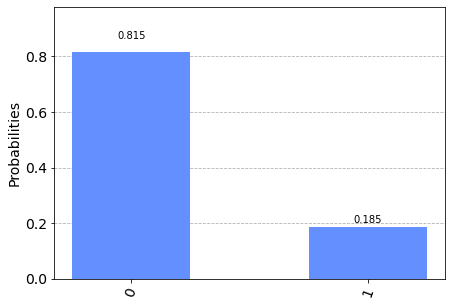

In [7]:
sim = Aer.get_backend('aer_simulator')  # Tell Qiskit how to simulate our circuit

qobj = assemble(circuito.decompose())     # Create a Qobj from the circuit for the simulator to run
counts = sim.run(qobj).result().get_counts()
plot_histogram(counts)

In [333]:
n_epochs = 30   # Number of optimization epochs
n_train = 50    # Size of the train dataset
n_test = 30
n_batch = 5     # Size of the test dataset
threshold = 0.85
spsa = SPSA(maxiter=20,blocking= True)

### Pre processamento

In [439]:
mnist_dataset = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist_dataset.load_data()

train_mask = np.isin(Y_train, [0,1])
test_mask = np.isin(Y_test, [0,1])

X_train, Y_train = X_train[train_mask], np.array(Y_train[train_mask] == 1)
X_test, Y_test = X_test[test_mask], np.array(Y_test[test_mask] == 1)


In [438]:
print(Y_test)

[7 2 1 ... 4 5 6]


### Diminuindo o tamanho das amostras

In [440]:
weightImageOne = X_test[51] #number one 51

X_train = X_train[:n_train]
Y_train = Y_train[:n_train]

X_test = X_test[:n_test]
Y_test = Y_test[:n_test]

### Normalizando as amostras entre zero e $\pi$

In [441]:
X_train = (X_train/255)*(np.pi/2)
X_test= (X_test/255)*(np.pi/2)

weightImageOne = (weightImageOne/255)*(np.pi/2)

In [276]:
for i in Y_train:
    print(i)

False
True
True
True
True
False
True
True
False
False
True
False
False
True
False
True
False
False
True
True
False
True
True
False
False
False
True
True
True
True
False
True
True
False
False
False
False
True
True
True
True
False
False
True
True
True
False
True
True
True


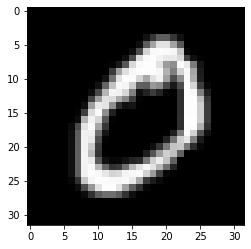

In [442]:
X_train = np.expand_dims(X_train, axis=-1)
X_train = tf.image.resize(X_train, [32,32])

X_test = np.expand_dims(X_test, axis=-1)
X_test = tf.image.resize(X_test, [32,32])

weightImageOne = np.expand_dims(weightImageOne, axis=-1)
weightImageOne = tf.image.resize(weightImageOne, [32,32])
plt.imshow(X_train[0], cmap= "gray")
plt.show()

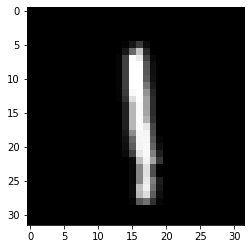

False


In [444]:
plt.imshow(X_train[3], cmap= "gray")
plt.show()
print(Y_train[0])

### Transformando imagem em lista de array

In [2]:
def transformImageInArray(image):
    imageArray = []
    for i in range(32):
        for j in range(32):
            imageArray.append(float(image[i][j]))
    return imageArray

### Criando Circuito

In [267]:
def createCircuit(imageArray, weightArray):
    numQbits = int(np.log2(len(weightArray)))

    register = QuantumRegister(numQbits)
    output = QuantumRegister(1, name='output')
    classicalBit = ClassicalRegister(1)

    circuit = QuantumCircuit(register, output, classicalBit)

    circuit.append(Ui(imageArray), [0,1,2,3,4,5,6,7,8,9])
    circuit.barrier()
    circuit.append(Uw(weightArray), [0,1,2,3,4,5,6,7,8,9])
    circuit.mcx([0,1,2,3,4,5,6,7,8,9], 10)
    circuit.measure(10,0)
    return circuit

### Funçoes auxiliares

In [202]:
def getlost(ytil, y):
    return (y - ytil)**2

In [271]:
def loss(weight):

    circuit = createCircuit(transformImageInArray(imagem), weight)
    sim = Aer.get_backend('aer_simulator')  # Tell Qiskit how to simulate our circuit
    qobj = assemble(circuit.decompose())     # Create a Qobj from the circuit for the simulator to run
    counts = sim.run(qobj).result().get_counts()
    print("Keys: "+str(counts.keys()))
    print(counts)
    try:
        if(counts['1']/1024 > threshold): ytil = 1 
        else: ytil = 0
    except:
        ytil = 0
    return getlost(ytil, imagemLabel)

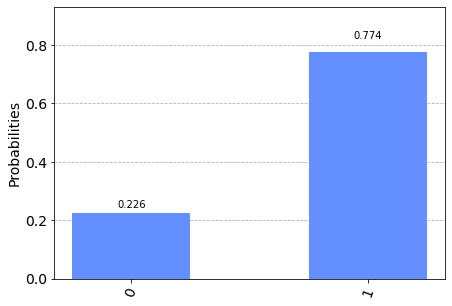

In [334]:
circuit = createCircuit(transformImageInArray(X_train[8]), weightArray)
sim = Aer.get_backend('aer_simulator')  # Tell Qiskit how to simulate our circuit
qobj = assemble(circuit.decompose())     # Create a Qobj from the circuit for the simulator to run
counts = sim.run(qobj).result().get_counts()
plot_histogram(counts)


In [ ]:
imagem = X_train[4]
imagemLabel = Y_train[4]
weightArray = transformImageInArray(weightImageOne)
for i in range(50):
    imagem = X_train[i]
    imagemLabel = Y_train[i]
    weightArray = spsa.optimize(num_vars = 1024, variable_bounds= list((0, np.pi/2) for i in range (1024)), objective_function = loss ,initial_point=weightArray)[0]
    


## Train

In [355]:
count = 0
count0 = 0
count1 = 0
for i in range(30):
    circuit = createCircuit(transformImageInArray(X_test[i]), weightArray)
    sim = Aer.get_backend('aer_simulator')  # Tell Qiskit how to simulate our circuit
    qobj = assemble(circuit.decompose())     # Create a Qobj from the circuit for the simulator to run
    counts = sim.run(qobj).result().get_counts()
    if (counts['1']/1024 > threshold):
        result = 1
    else:
        result = 0
    #print("Result: "+str(result)+ " Label: "+str(Y_test[i]))
    if result == Y_test[i]:
        count += 1
    else:
        if result == 0:
            count0 += 1
        else:
            count1 += 1
    
print(count/30)
print("erro 0: "+str(count0) + str(count0/30))
print("erro 1: "+str(count1) + str(count1/30))

1.0
erro 0: 00.0
erro 1: 00.0


## Perceptron Clássico

In [25]:
mnist_dataset = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist_dataset.load_data()

train_mask = np.isin(Y_train, [0,1])
test_mask = np.isin(Y_test, [0,1])

X_train, Y_train = X_train[train_mask], np.array(Y_train[train_mask] == 1)
X_test, Y_test = X_test[test_mask], np.array(Y_test[test_mask] == 1)

In [26]:
weightImageOne = X_test[51] #number one 51

X_train, X_val = X_train[:n_train], X_train[n_train:]
Y_train, Y_val = Y_train[:n_train], Y_train[n_train:]

X_test = X_test[:n_test]
Y_test = Y_test[:n_test]

In [27]:
X_train = X_train/255
X_test= X_test/255

weightImageOne = weightImageOne/255

In [28]:
from sklearn.preprocessing import LabelBinarizer
X_train = X_train.reshape([X_train.shape[0], -1])
X_val = X_val.reshape([X_val.shape[0], -1])
X_test = X_test.reshape([X_test.shape[0], -1])
lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_test = lb.transform(Y_test)

In [562]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron
model = Perceptron()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
countClassic = (mean(scores))

Mean Accuracy: 0.993 (0.036)


## Redes Neurais

### Rede Neural 1

In [107]:
n_train = 50
n_test = 30

In [108]:
mnist_dataset = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist_dataset.load_data()

train_mask = np.isin(Y_train, [0,1])
test_mask = np.isin(Y_test, [0,1])

X_train, Y_train = X_train[train_mask], np.array(Y_train[train_mask] == 1)
X_test, Y_test = X_test[test_mask], np.array(Y_test[test_mask] == 1)


In [109]:
X_train, X_val = X_train[:n_train], X_train[n_train:]
Y_train, Y_val = Y_train[:n_train], Y_train[n_train:]

X_test = X_test[:n_test]
Y_test = Y_test[:n_test]

In [110]:
X_train = X_train/255
X_test= X_test/255

In [111]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [112]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [113]:
model.fit(X_train, Y_train, epochs=10)

Epoch 1/10
2/2 [==============================] - 0s 4ms/step - loss: 2.2328 - accuracy: 0.0600
Epoch 2/10
2/2 [==============================] - 0s 3ms/step - loss: 1.3243 - accuracy: 0.8200
Epoch 3/10
2/2 [==============================] - 0s 2ms/step - loss: 0.7231 - accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 0s 3ms/step - loss: 0.4015 - accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 0s 5ms/step - loss: 0.2162 - accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 0s 4ms/step - loss: 0.1194 - accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0702 - accuracy: 1.0000
Epoch 8/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0433 - accuracy: 1.0000
Epoch 9/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0276 - accuracy: 1.0000
Epoch 10/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0183 - accuracy: 1.0000


In [114]:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
countRn1 = test_acc

1/1 - 0s - loss: 0.0278 - accuracy: 1.0000 - 122ms/epoch - 122ms/step


In [20]:
predictions = model.predict(X_test)

In [21]:
predictions[0]

array([0.04263221, 0.8977124 , 0.01071811, 0.00731495, 0.00328268,
       0.00531626, 0.00676763, 0.00918508, 0.00966574, 0.00740501],
      dtype=float32)

In [51]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

<ipython-input-51-8a8f4d122335>:25: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  thisplot[true_label].set_color('blue')


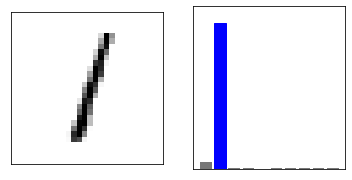

In [52]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, Y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  Y_test)
plt.show()

<ipython-input-51-8a8f4d122335>:25: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  thisplot[true_label].set_color('blue')


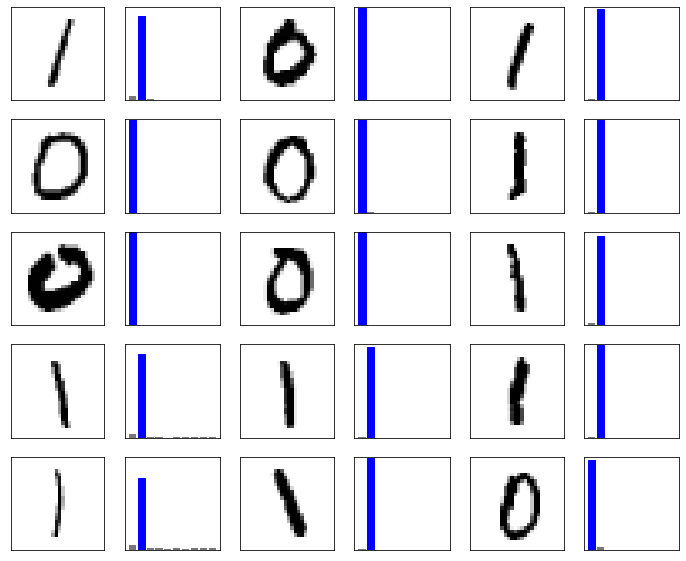

In [53]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, Y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, Y_test)
plt.show()

### Rede Neural 2

In [82]:
mnist_dataset = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist_dataset.load_data()

train_mask = np.isin(Y_train, [0,1])
test_mask = np.isin(Y_test, [0,1])

X_train, Y_train = X_train[train_mask], np.array(Y_train[train_mask] == 1)
X_test, Y_test = X_test[test_mask], np.array(Y_test[test_mask] == 1)

In [83]:
X_train, X_val = X_train[:n_train], X_train[n_train:]
Y_train, Y_val = Y_train[:n_train], Y_train[n_train:]

X_test = X_test[:n_test]
Y_test = Y_test[:n_test]

In [84]:
X_train = X_train/255
X_test= X_test/255

In [85]:
from sklearn.preprocessing import LabelBinarizer
X_train = X_train.reshape([X_train.shape[0], -1])
X_val = X_val.reshape([X_val.shape[0], -1])
X_test = X_test.reshape([X_test.shape[0], -1])
lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_test = lb.transform(Y_test)

In [62]:
import warnings
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split


mlp = MLPClassifier(
    hidden_layer_sizes=(40,),
    max_iter=8,
    alpha=1e-4,
    activation= 'relu',
    solver="sgd",
    verbose=10,
    random_state=1,
    learning_rate_init=0.2,
)

# this example won't converge because of resource usage constraints on
# our Continuous Integration infrastructure, so we catch the warning and
# ignore it here
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp.fit(X_train, Y_train)

print("Training set score: %f" % mlp.score(X_train, Y_train))
print("Test set score: %f" % mlp.score(X_test, Y_test))
countRn2 = mlp.score(X_test, Y_test)

Iteration 1, loss = 0.70507413
Iteration 2, loss = 0.18022826
Iteration 3, loss = 0.05555547
Iteration 4, loss = 0.01891512
Iteration 5, loss = 0.00696301
Iteration 6, loss = 0.00279096
Iteration 7, loss = 0.00123564
Iteration 8, loss = 0.00061564
Training set score: 1.000000
Test set score: 1.000000


/home/jp/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Rede Neural 3

In [90]:
mnist_dataset = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist_dataset.load_data()

train_mask = np.isin(Y_train, [0,1])
test_mask = np.isin(Y_test, [0,1])

X_train, Y_train = X_train[train_mask], np.array(Y_train[train_mask] == 1)
X_test, Y_test = X_test[test_mask], np.array(Y_test[test_mask] == 1)

In [91]:
X_train, X_val = X_train[:n_train], X_train[n_train:]
Y_train, Y_val = Y_train[:n_train], Y_train[n_train:]

X_test = X_test[:n_test]
Y_test = Y_test[:n_test]

In [92]:
X_train = X_train/255
X_test= X_test/255

In [93]:
from sklearn.preprocessing import LabelBinarizer
X_train = X_train.reshape([X_train.shape[0], -1])
X_val = X_val.reshape([X_val.shape[0], -1])
X_test = X_test.reshape([X_test.shape[0], -1])
lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_test = lb.transform(Y_test)

In [103]:
import warnings
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split


mlp = MLPClassifier(
    hidden_layer_sizes=(10,),
    max_iter=2,
    alpha=1e-4,
    activation= 'identity',
    solver="adam",
    verbose=10,
    random_state=1,
    learning_rate='adaptive',
    learning_rate_init=10,
)

# this example won't converge because of resource usage constraints on
# our Continuous Integration infrastructure, so we catch the warning and
# ignore it here
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp.fit(X_train, Y_train)

print("Training set score: %f" % mlp.score(X_train, Y_train))
print("Test set score: %f" % mlp.score(X_test, Y_test))
countRn3 = mlp.score(X_test, Y_test)

Iteration 1, loss = 0.81841001
Iteration 2, loss = 35.75197200
Training set score: 0.940000
Test set score: 0.966667


/home/jp/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Conclusão

In [123]:
results = {'Quântico':count,'Classico':countClassic,'RN1': countRn1, 'RN2': countRn2, 'RN3': countRn3}

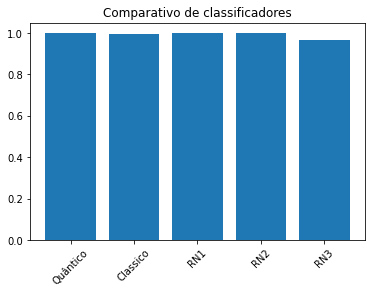

In [130]:
p = plt.bar(results.keys(), results.values(), align='center')
plt.xticks(rotation=45)
plt.title('Comparativo de classificadores')
plt.show()

In [135]:
#test = open('bestWeight.txt', 'r')
#testlist = test.readlines()
#testlist = list(map(float, testlist))
#print(testlist)